# 🧠 WiDS Datathon++ 2025 University Challenge
## **Unraveling the Mysteries of the Female Brain: Functional Networks Throughout Childhood Development**
---

### **👥 Team Members**
- **Rosali Gonzalez**
- **Hieu Chu**
- **Wenfong Wang**

---

## **📖 Introduction**
This project, part of the **WiDS Datathon++ University Challenge**, explores **how brain networks develop differently in males and females** during childhood and adolescence.  
The challenge **concludes on June 30, 2025**.

---

## **📊 DATA**
🔹 **fMRI Data** from **HBN** shows the **average activity** of regions of interest.  
🔹 **2D Connectome Matrices** (200 × 200) representing **functional connectivity** between brain regions.  
🔹 **Dataset Size**: **1,578 adolescents**  
   - **1,104 participants (Train Set)**  
   - **474 participants (Test Set)**  

---

### **🎯 Project Goals**
1️⃣ **Build a model** to predict age from **functional connectome matrices**  
2️⃣ **Investigate sex-based differences** in brain development  
3️⃣ **Gain insights into mental health & cognitive development**

---

## **🔍 Key Research Questions**
Our primary goal is to **understand how brain networks develop differently across males and females** in adolescence.  
The visualizations in this notebook will focus on:

✅ **Sex-based differences** in brain activity  
✅ **Age-related changes** in brain connectivity  
✅ **Relationships between brain activity & psychological traits**  
✅ **Network-based comparisons** of high- vs. low-activity brain regions  

---


In [1]:
#import library
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import tqdm
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Define helper function

def get_numeric_columns(df):
    """
    Returns a list of numeric columns in the dataframe, excluding 'participant_id'.
    """
    return df.select_dtypes(include=[np.number]).columns.tolist()

def compute_mean_connectivity(df):
    """
    Computes mean brain connectivity per participant.
    """
    numeric_cols = get_numeric_columns(df)
    df["mean_connectivity"] = df[numeric_cols].iloc[:, 1:].mean(axis=1)  # Excluding 'participant_id'
    return df

def compute_sex_based_connectivity(df):
    """
    Computes mean connectivity for males and females.
    Returns male connectivity, female connectivity, and the difference.
    """
    numeric_cols = get_numeric_columns(df)
    
    male_connectivity = df[df["sex_Male"] == True][numeric_cols].mean()
    female_connectivity = df[df["sex_Male"] == False][numeric_cols].mean()
    
    connectivity_diff = male_connectivity - female_connectivity
    return male_connectivity, female_connectivity, connectivity_diff

### i) Extract a row of correlations from the Upper Triangular portion of the 2 dimensional, creating a vector of correlations for each individual.

### ii) Perform processing operations on both train and test set 


In [3]:
def extract_upper_triangular(matrix):
    """
    Extract the upper triangular portion of a 2D matrix, excluding the diagonal.
    """
    upper_triangular = matrix[np.triu_indices_from(matrix, k=1)]  # Exclude the diagonal with k=1
    return upper_triangular

def process_file(file_path):
    """
    Process a single file to extract the upper triangular features and participant ID.
    """
    # Read the connectome matrix
    matrix = pd.read_csv(file_path, sep='\t', header=None).values
    # Validate matrix size
    if matrix.shape != (200, 200):
        raise ValueError(f"Invalid matrix shape {matrix.shape} in file: {file_path}")
    # Extract upper triangular features
    features = extract_upper_triangular(matrix)
    # Extract participant ID by removing "sub-" prefix
    participant_id = file_path.split('/')[-1].split('_')[0].replace("sub-", "")
    return participant_id, features

def process_dataset(directory):
    """
    Process all files in a given directory to extract features and participant IDs.
    """
    features_list = []
    for file in tqdm.tqdm(os.listdir(directory)):
        if file.endswith(".tsv"):
            file_path = os.path.join(directory, file)
            try:
                participant_id, features = process_file(file_path)
                features_list.append([participant_id] + list(features))
            except ValueError as e:
                print(e)
    return features_list

def create_dataframe(features_list, matrix_size):
    """
    Create a DataFrame from the features list with appropriate feature column names.
    """
    num_features = matrix_size * (matrix_size - 1) // 2  # Number of upper triangular features
    feature_columns = ['participant_id'] + [f'feature_{i}' for i in range(num_features)]
    features_df = pd.DataFrame(features_list, columns=feature_columns)
    return features_df

# Directories
train_tsv_dir = r'./widsdatathon2025-university/train_tsv/train_tsv'
test_tsv_dir = r'./widsdatathon2025-university/test_tsv/test_tsv'

# Process datasets
train_features_list = process_dataset(train_tsv_dir)
test_features_list = process_dataset(test_tsv_dir)

# Create DataFrames
matrix_size = 200
train_features_df = create_dataframe(train_features_list, matrix_size)
test_features_df = create_dataframe(test_features_list, matrix_size)

100%|█████████████████████████████████████████| 474/474 [00:07<00:00, 62.52it/s]


In [4]:
train_features_df.head()

,participant_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_19890,feature_19891,feature_19892,feature_19893,feature_19894,feature_19895,feature_19896,feature_19897,feature_19898,feature_19899
0,NDAREE015WGU,0.074628,0.673757,0.813541,0.725489,0.823861,0.801859,0.690204,0.450536,0.602295,...,-0.085699,-0.384692,0.144188,0.028936,0.459860,0.034850,-0.013038,0.136324,0.307616,0.651800
1,NDARNV694EMG,0.167241,0.549381,0.453434,0.132590,0.496156,0.337475,0.506641,0.215110,0.564849,...,-0.182810,-0.218310,0.121466,0.385125,0.238837,0.259410,0.295100,0.173912,0.146515,0.745695
2,NDARFR108JNB,0.197198,0.337779,0.018934,0.580793,0.728406,0.507803,0.470236,0.401553,0.547191,...,0.123635,-0.275289,-0.128840,-0.127517,0.204607,-0.053665,0.014747,0.386666,0.101631,0.392795
3,NDARZF170TZ0,0.370992,0.546226,0.659874,0.212565,0.429793,0.352411,0.047157,0.112740,0.012267,...,0.301385,-0.024348,0.023625,0.071900,0.419424,0.463888,0.406361,0.552444,0.491682,0.761957
4,NDARYJ334EHH,0.127956,0.415074,0.219740,0.311787,0.650690,0.615524,0.597610,0.334451,0.327396,...,0.387702,0.226518,0.110955,0.165357,0.666903,0.313224,0.407230,0.393838,0.608498,0.732935


In [5]:
test_features_df.head()

,participant_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_19890,feature_19891,feature_19892,feature_19893,feature_19894,feature_19895,feature_19896,feature_19897,feature_19898,feature_19899
0,NDARVC195NLH,0.168761,0.771693,0.751037,0.333392,0.591943,0.389689,0.346864,0.383026,0.369321,...,0.214968,0.299955,0.284884,0.302903,0.580764,0.531170,0.461170,0.766840,0.633278,0.748329
1,NDARRJ763GUF,0.608355,0.635795,0.666729,0.133881,0.414057,0.132983,0.351283,-0.100276,0.416341,...,0.145374,0.114192,0.192043,0.208902,0.772665,0.592846,0.574259,0.765728,0.587564,0.559012
2,NDARVD552PRC,-0.001465,0.663387,0.488384,0.405682,0.486694,0.521664,0.564425,0.442218,0.548302,...,0.071465,0.151082,0.023181,-0.015978,0.624047,0.424277,0.366675,0.459669,0.397081,0.629329
3,NDARFW578RU9,-0.105788,0.706254,0.510611,0.543470,0.604265,0.809928,0.724216,0.518143,0.560565,...,-0.367442,-0.499903,-0.399016,-0.207148,0.728662,0.598511,0.608956,0.489813,0.553503,0.581121
4,NDARNV124WR8,0.144576,0.384320,0.392174,0.323350,0.577024,0.555873,0.436705,0.053787,0.349211,...,-0.062198,-0.244840,-0.051612,-0.041485,0.651209,0.470194,0.235269,0.568364,0.547307,0.590414


### iii) Concatenate Training and Test dataframes with respective metadata.

We also look at missing values and data types in these datasets.

In [6]:
train_metadata_path = r'./widsdatathon2025-university/metadata/training_metadata.csv'
test_metadata_path = r'./widsdatathon2025-university/metadata/test_metadata.csv'

# Load metadata
train_metadata = pd.read_csv(train_metadata_path)
test_metadata = pd.read_csv(test_metadata_path)

In [7]:
def explore_data(df):
    # Create a summary DataFrame
    summary = pd.DataFrame({
        'Data Type': df.dtypes,
        'Missing Values': df.isnull().sum(),
        'Unique Values': df.nunique(),
        'Mean': df.mean(numeric_only=True),
        'Median': df.median(numeric_only=True),
        'Standard Deviation': df.std(numeric_only=True),
        'Min': df.min(numeric_only=True),
        'Max': df.max(numeric_only=True)
    })
    
    # Add additional statistics for categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        summary.loc[col, 'Most Common Value'] = df[col].mode()[0]
        summary.loc[col, 'Frequency of Most Common'] = df[col].value_counts().iloc[0]
    
    return summary

train_summary = explore_data(train_metadata)
print(train_summary)

                   Data Type  Missing Values  Unique Values       Mean  \
age                  float64               0            684  11.190634   
attention_fs         float64               0            373   0.079158   
bmi                  float64              18            743  19.835580   
ethnicity             object             109              2        NaN   
externalizing_fs     float64               0            379   0.094810   
handedness            object               0              3        NaN   
internalizing_fs     float64               0            378   0.103197   
p_factor_fs          float64               0            335   0.218623   
parent_1_education    object             183              4        NaN   
parent_2_education    object              22              4        NaN   
participant_id        object               0           1104        NaN   
race                  object             168              4        NaN   
sex                   object          

In [8]:
def preprocess_data(df):
    df_processed = df.copy()
    
    # Separate the participant_id column
    participant_id = df_processed['participant_id']
    
    # Drop participant_id from the DataFrame for preprocessing
    df_processed = df_processed.drop(columns=['participant_id'])
    
    # Impute missing values for numeric columns (using mean)
    numeric_cols = df_processed.select_dtypes(include=['float64', 'int64']).columns
    numeric_imputer = SimpleImputer(strategy='mean')
    df_processed[numeric_cols] = numeric_imputer.fit_transform(df_processed[numeric_cols])
    
    # Impute missing values for categorical columns (using most frequent value)
    categorical_cols = df_processed.select_dtypes(include=['object', 'category']).columns
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    df_processed[categorical_cols] = categorical_imputer.fit_transform(df_processed[categorical_cols])
    
    # One-hot encode categorical variables
    df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)
    
    # Add the participant_id column back to the DataFrame
    df_processed['participant_id'] = participant_id
    
    return df_processed

train_processed = preprocess_data(train_metadata)
print("Shape of processed train data:", train_processed.shape)
train_processed.head()

Shape of processed train data: (1104, 23)


,age,bmi,p_factor_fs,internalizing_fs,externalizing_fs,attention_fs,sex_Male,study_site_HBNsiteCUNY,study_site_HBNsiteRU,study_site_HBNsiteSI,...,race_White,handedness_Left,handedness_Right,parent_1_education_Complete_secondary,parent_1_education_Complete_tertiary,parent_1_education_No_incomplete primary,parent_2_education_Complete_secondary,parent_2_education_Complete_tertiary,parent_2_education_No_incomplete primary,participant_id
0,15.33,28.52,0.32,1.79,1.20,-1.62,False,False,False,False,...,True,False,True,False,True,False,False,True,False,NDARZE963MEU
1,9.43,16.23,-1.48,-0.80,-0.36,0.96,False,False,False,False,...,True,False,True,False,True,False,False,True,False,NDARCB305AFY
2,13.85,16.27,0.02,-1.54,0.84,1.11,True,False,False,False,...,False,False,True,False,True,False,False,True,False,NDARKK597VDH
3,9.68,16.55,1.29,-0.22,0.74,-0.97,False,False,True,False,...,False,True,False,False,False,False,False,True,False,NDARMR277TT7
4,12.79,14.27,-0.15,0.69,-1.08,-0.29,True,False,False,False,...,True,False,True,False,True,False,True,False,False,NDARDB161LU6


In [9]:
test_processed = preprocess_data(test_metadata)
print("Shape of processed test data:", test_processed.shape)
test_processed.head()

Shape of processed test data: (474, 22)


,bmi,p_factor_fs,internalizing_fs,externalizing_fs,attention_fs,sex_Male,study_site_HBNsiteCUNY,study_site_HBNsiteRU,study_site_HBNsiteSI,ethnicity_Not_Hispanic_or_Latino,...,race_White,handedness_Left,handedness_Right,parent_1_education_Complete_secondary,parent_1_education_Complete_tertiary,parent_1_education_No_incomplete primary,parent_2_education_Complete_secondary,parent_2_education_Complete_tertiary,parent_2_education_No_incomplete primary,participant_id
0,15.85,1.03,1.11,-0.84,0.01,True,False,True,False,True,...,True,False,True,False,True,False,False,True,False,NDARHC737MHK
1,14.86,-1.61,-0.74,-0.31,-0.43,False,False,False,True,True,...,True,False,True,False,True,False,False,True,False,NDARAA075AMK
2,20.41,0.41,0.30,-0.06,0.82,True,False,False,True,True,...,True,False,True,False,False,False,False,True,False,NDARGY148EVU
3,17.36,-0.81,0.00,2.13,0.33,True,False,False,False,True,...,True,False,True,False,True,False,False,True,False,NDARZA511FYF
4,16.03,-0.87,2.45,-0.63,-0.82,True,False,False,False,True,...,False,False,True,False,True,False,False,True,False,NDARDE877RFH


##### Concatenate connectome data into metadata

In [10]:
train_combined = pd.merge(train_processed, train_features_df, on='participant_id', how='inner')
test_combined = pd.merge(test_processed, test_features_df, on='participant_id', how='inner')

# Save the combined datasets
train_combined.to_csv(r'./widsdatathon2025-university/processed_data/processed_train_data.csv', index=False)
test_combined.to_csv(r'./widsdatathon2025-university/processed_data/processed_test_data.csv', index=False)

print("Merged features with metadata in training set", train_combined.shape)
print("Merged features with metadata in testing set", test_combined.shape)

Merged features with metadata in training set (1104, 19923)
Merged features with metadata in testing set (474, 19922)


#### Check missing values after processing (imputation)

In [11]:
# Check for missing values in the training set
train_missing_values = train_combined.isnull().sum()
print("Missing values in training set after processing:")
print(train_missing_values.sum())

# Check for missing values in the testing set
test_missing_values = test_combined.isnull().sum()
print("Missing values in testing set after processing:")
print(test_missing_values.sum())

Missing values in training set after processing:
0
Missing values in testing set after processing:
0


#### Check duplicated values after processing (imputation)

In [12]:
# Check for duplicated values in the training set
train_duplicated_values = train_combined.duplicated().sum()
print("Duplicated values in training set after processing:")
print(train_duplicated_values.sum())

# Check for duplicated values in the testing set
test_duplicated_values = test_combined.duplicated().sum()
print("Duplicated values in testing set after processing:")
print(test_duplicated_values.sum())

Duplicated values in training set after processing:
0
Duplicated values in testing set after processing:
0


#### Check unmatched IDs between processed data and metadata

In [13]:
test_processed_ids = set(test_combined['participant_id'])
test_features_ids = set(test_metadata['participant_id'])

# Extract participant_id from the merged test dataset
test_combined_ids = set(test_combined['participant_id'])

# Find unmatched IDs in test_processed but not in test_combined
unmatched_test_processed = test_processed_ids - test_combined_ids
if len(unmatched_test_processed) == 0:
    print("All participant IDs in the processed test data match with metadata.")
else:
    
    print("Unmatched participant_id in test_processed but not in test_combined:", unmatched_test_processed)

train_processed_ids = set(train_combined['participant_id'])
train_features_ids = set(train_metadata['participant_id'])

# Extract participant_id from the merged dataset
train_combined_ids = set(train_combined['participant_id'])

# Find unmatched IDs in train_processed but not in train_combined
unmatched_train_processed = train_processed_ids - train_combined_ids
if len(unmatched_train_processed) == 0:
    print("All participant IDs in the processed train data match with metadata.")
else:
    print("Unmatched participant_id in train_processed but not in train_combined:", unmatched_train_processed)


All participant IDs in the processed test data match with metadata.
All participant IDs in the processed train data match with metadata.


### Check age balance between two sexes

Here we observe the age distribution (25%,50%, 75%) are approximately the same for two sexes. Thus, the age target values are balanced between 2 sexes. 

In [14]:
age_balance_by_sex = train_combined.groupby('sex_Male')['age'].describe()

# Print the age distribution by sex
print("Age distribution by sex in the training set:")
print(age_balance_by_sex)

Age distribution by sex in the training set:
          count       mean       std   min    25%    50%      75%    max
sex_Male                                                                
False     416.0  11.353822  3.393187  5.05  8.735  10.81  13.7175  21.90
True      688.0  11.091962  3.133775  5.27  8.610  10.51  13.3300  20.49


**Age**: We first look at the age distribution, it's slightly right-skewed, so most of the study would focus on younger ages (7.5-12 years old). People at those ages observe the most brain development activity.

**BMI**: This is also tilted towards medium 18-20 range, which is healthy range for people.

**p_factor_fs**: shows normal distribution which is good for the machine learning task to have a variety of range in brain disorderness. 

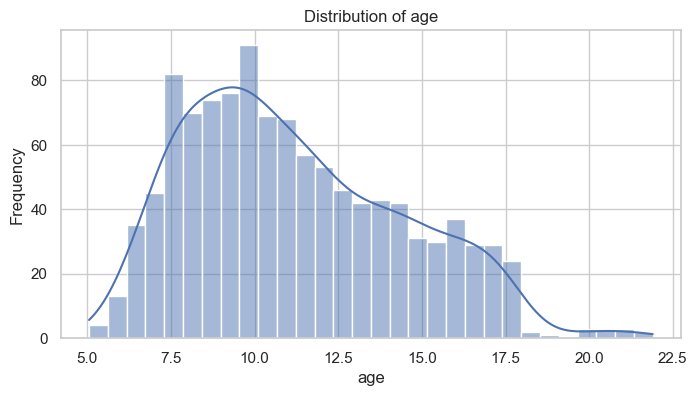

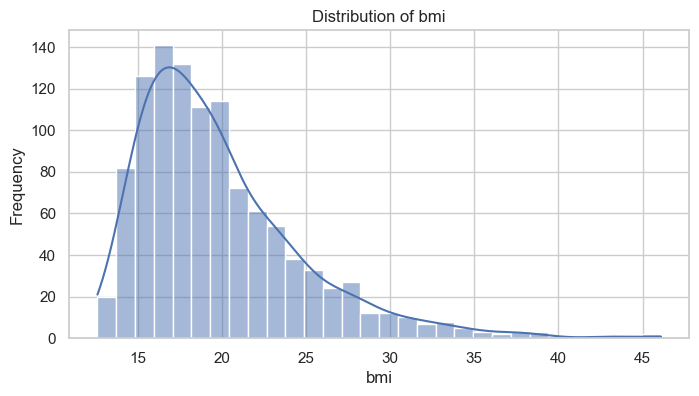

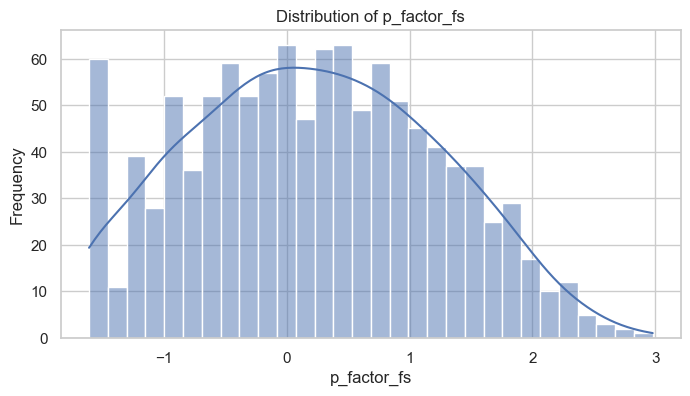

In [15]:
sns.set(style="whitegrid")
    
# Define numeric and categorical columns
numeric_cols = ['age', 'bmi', 'p_factor_fs', 'internalizing_fs', 'externalizing_fs', 'attention_fs']
categorical_cols = ['sex_Male', 'study_site_HBNsiteCUNY', 'study_site_HBNsiteRU', 'study_site_HBNsiteSI',
                    'ethnicity_Not_Hispanic_or_Latino', 'race_Black', 'race_Other', 'race_White',
                    'handedness_Left', 'handedness_Right', 'parent_1_education_Complete_secondary',
                    'parent_1_education_Complete_tertiary', 'parent_1_education_No_incomplete primary',
                    'parent_2_education_Complete_secondary', 'parent_2_education_Complete_tertiary',
                    'parent_2_education_No_incomplete primary']

# 1. Distribution plots for a few numeric columns
for col in numeric_cols[:3]:  # Plot first 3 numeric columns
    plt.figure(figsize=(8, 4))
    sns.histplot(train_combined[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

We conducted pairplots for metadata variables, revealing clear trends in age-BMI and p-factor vs. attention_fs. Most distributions are right-skewed, indicating higher frequencies of lower values with fewer extreme high values, typical in psychological data. However, attention_fs is slightly left-skewed, suggesting higher attention-related issues are more common, with fewer low scores. These patterns highlight key relationships and distributional characteristics, aiding further analysis and interpretation.

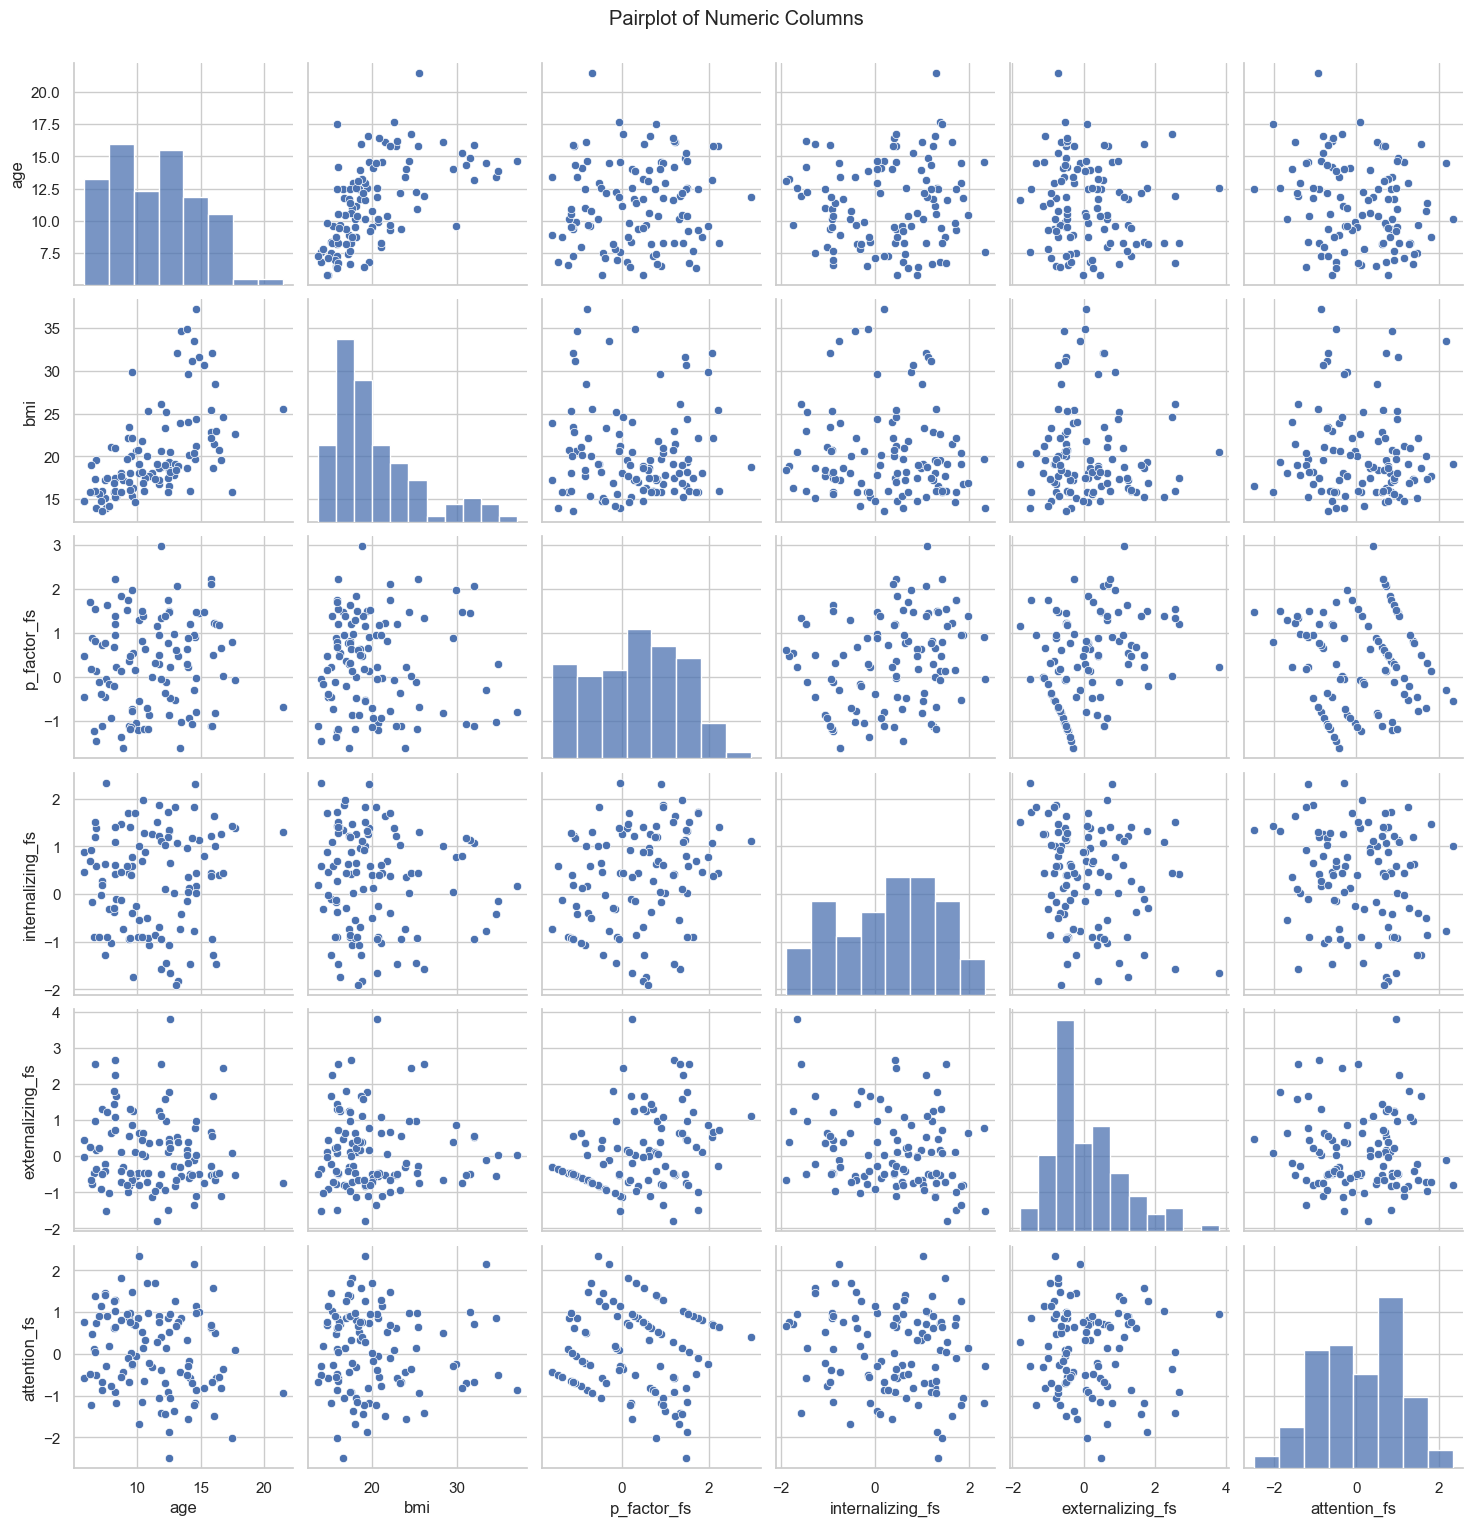

In [16]:
sns.pairplot(train_combined[numeric_cols].sample(frac=0.1))  # Sample 10% of data for speed
plt.suptitle('Pairplot of Numeric Columns', y=1.02)
plt.show()

### Feature Engineering

In [17]:
connectome_features = train_combined[[feat_col for feat_col in train_combined.columns if feat_col.startswith("feature_")]]
mean_features = connectome_features.mean(0)


The plot below compares the activity levels of the top 1000 high-activity brain features with the lowest 1000 low-activity brain features, based on their mean activity levels. The plot effectively visualizes the disparity between these two groups, highlighting the variability in brain activity across different regions or connections.

The top 1000 high-activity features exhibit significantly higher mean activity levels, indicating regions or connections in the brain that are highly active. These features likely represent key neural pathways or regions that contribute substantially to the observed brain activity patterns. Such high-activity features could be prioritized for further analysis or as potential biomarkers in neurological studies due to their significant role in brain function.

On the other hand, the lowest 1000 low-activity features show minimal activity, suggesting regions or connections that are less engaged or inactive. These features may represent less critical or dormant neural pathways. While they may not play a prominent role in the overall brain activity, they could still provide valuable insights into underactive or suppressed brain regions, which might be relevant in certain neurological conditions or states.

The sharp contrast between the high and low activity features underscores the importance of identifying and understanding the most active regions of the brain.

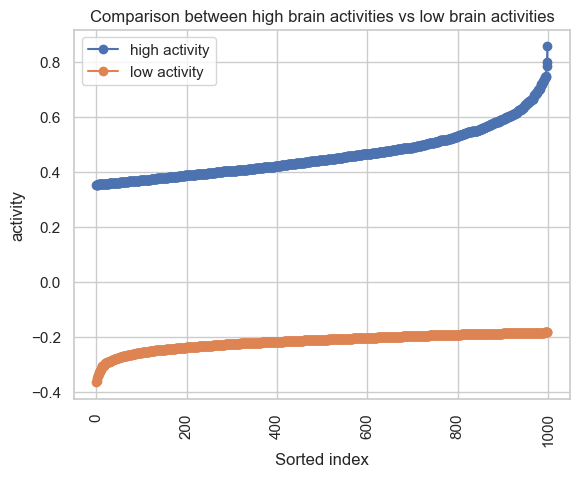

In [18]:
sorted_features = np.sort(mean_features)
plt.plot(sorted_features[-1000:],"o-", label = "high activity")
plt.plot(sorted_features[:1000],"o-", label = "low activity")
plt.xticks(rotation = 90)
plt.legend()
plt.title("Comparison between high brain activities vs low brain activities")
plt.ylabel("activity")
plt.xlabel("Sorted index")
plt.show()


Below shown on average a lot of regions in the brain are not active (the distribution centered around 0), thus we need to use PCA (later) to reduce those regions and only keep the most important PCs.

Text(0, 0.5, 'count')

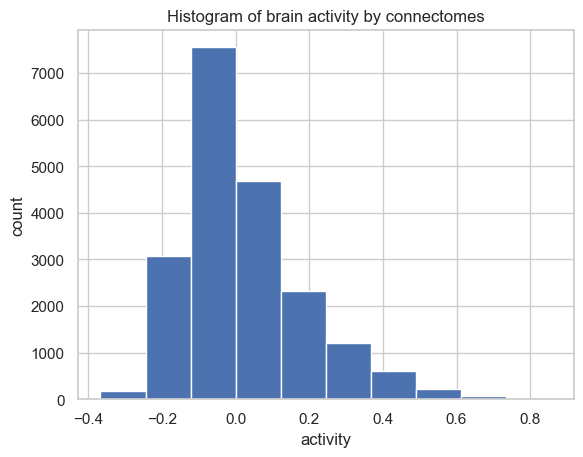

In [19]:
plt.hist(mean_features)
plt.title("Histogram of brain activity by connectomes")
plt.xlabel("activity")
plt.ylabel("count")

Mean values for males:
internalizing_fs    0.009564
externalizing_fs    0.149375
attention_fs        0.219462
dtype: float64

Mean values for females:
internalizing_fs    0.258053
externalizing_fs    0.004567
attention_fs       -0.152885
dtype: float64

T-tests for each factor between males and females:
T-test for internalizing_fs: t-statistic = [-3.96298614], p-value = [7.87805855e-05]
T-test for externalizing_fs: t-statistic = [2.18246881], p-value = [0.02928552]
T-test for attention_fs: t-statistic = [6.124318], p-value = [1.26506277e-09]


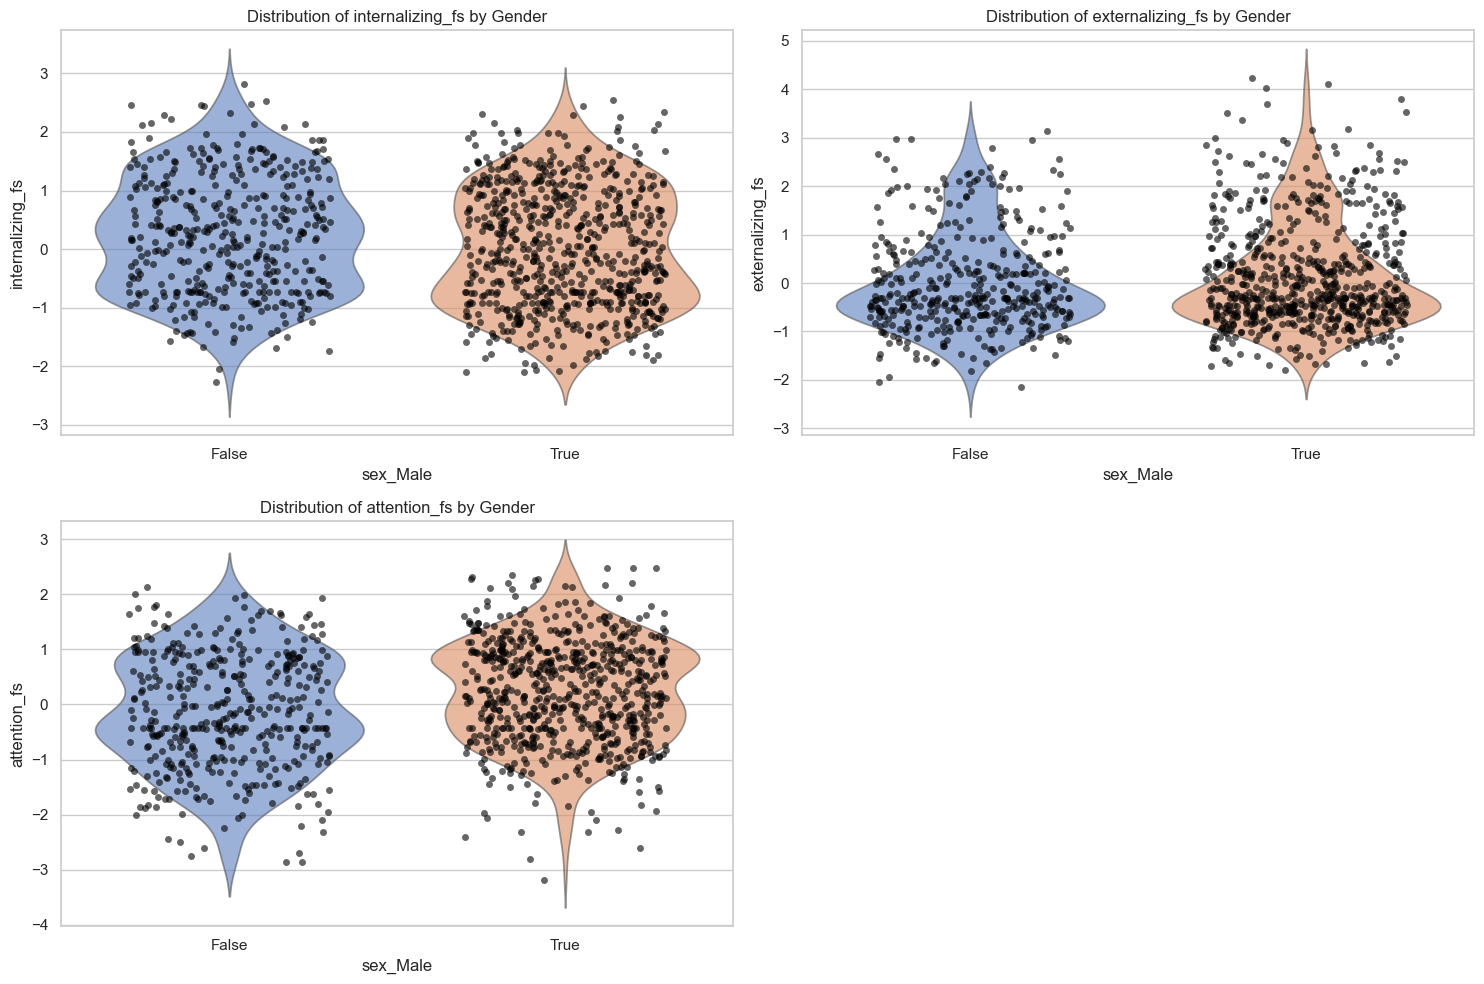


Summary of T-test results:
             Factor            T-statistic                   P-value
0  internalizing_fs  [-3.9629861437908103]   [7.878058548123848e-05]
1  externalizing_fs    [2.182468806664598]     [0.02928551896965334]
2      attention_fs    [6.124317996967253]  [1.2650627705394127e-09]


In [20]:
male_stats = train_combined[train_combined.sex_Male == True][['internalizing_fs', 'externalizing_fs', 'attention_fs']].mean()
female_stats = train_combined[train_combined.sex_Male== False][['internalizing_fs', 'externalizing_fs', 'attention_fs']].mean()

print("Mean values for males:")
print(male_stats)

print("\nMean values for females:")
print(female_stats)

# t-tests for each factor between males and females
print("\nT-tests for each factor between males and females:")
results = []
for factor in ['internalizing_fs', 'externalizing_fs', 'attention_fs']:
    male_values = train_combined[train_combined.sex_Male == True][[factor]]
    female_values = train_combined[train_combined.sex_Male== False][[factor]]
    
    t_stat, p_value = stats.ttest_ind(male_values, female_values)
    results.append((factor, t_stat, p_value))
    print(f"T-test for {factor}: t-statistic = {t_stat}, p-value = {p_value}")

# Visualization: Violin plot with strip plot overlay for each factor by gender
plt.figure(figsize=(15, 10))

for i, factor in enumerate(['internalizing_fs', 'externalizing_fs', 'attention_fs']):
    plt.subplot(2, 2, i + 1)
    
    # Violin plot shows the distribution of data
    sns.violinplot(x='sex_Male', y=factor, data=train_combined, inner=None, alpha=0.6, scale='width', palette="muted")
    
    # Strip plot shows individual data points
    sns.stripplot(x='sex_Male', y=factor, data=train_combined, color='black', jitter=0.3, alpha=0.6)
    
    plt.title(f'Distribution of {factor} by Gender')
    plt.ylabel(factor)

plt.tight_layout()
plt.show()

# Summary results DataFrame
summary_results_df = pd.DataFrame(results, columns=["Factor", "T-statistic", "P-value"])
print("\nSummary of T-test results:")
print(summary_results_df)

# Insights from the Results

## Mean Values by Gender
- **Males:** 0.009564  
- **Females:** 0.258053  
- **Insight:** Females exhibit **substantially higher internalizing scores**, suggesting they are **more prone to mood-related issues such as anxiety and depression**.

### Externalizing Factor
- **Males:** 0.149375  
- **Females:** 0.004567  
- **Insight:** Males have a **significantly higher externalizing score**, indicating they **engage in more aggressive, impulsive, or rule-breaking behaviors** compared to females.

### Attention Factor
- **Males:** 0.219462  
- **Females:** -0.152885  
- **Insight:** Males show **notably higher attention factor scores**, meaning they are **more likely to struggle with inattention and hyperactivity than females**.

---

## T-Test Results

### Internalizing Factor
- **T-statistic:** -3.96  
- **P-value:** 7.88e-05  
- **Interpretation:** The p-value is **very small (p < 0.05)**, indicating a **statistically significant difference**. **Females experience significantly more internalizing symptoms (e.g., anxiety, depression) than males.**

### Externalizing Factor
- **T-statistic:** 2.18  
- **P-value:** 0.0293  
- **Interpretation:** Since the p-value is **less than 0.05**, there is a **statistically significant difference**. **Males show significantly higher externalizing behaviors (e.g., aggression, conduct issues) than females.**

### Attention Factor
- **T-statistic:** 6.12  
- **P-value:** 1.27e-09  
- **Interpretation:** The extremely low p-value (**p < 0.05**) confirms a **highly significant difference**. **Males struggle far more with attention-related issues compared to females.**

---

## Summary of Insights

- **Females** have **significantly higher internalizing symptoms**, indicating they are **more prone to emotional distress** such as **anxiety and depression**.  
- **Males** exhibit **significantly higher externalizing behaviors**, meaning they are **more likely to engage in aggressive and impulsive actions**.  
- **Males also show significantly higher attention-related issues**, reinforcing the pattern that **boys tend to experience more difficulties with inattention and hyperactivity than girls**.  
- These findings suggest **distinct gender-based differences in mental health**, where **females internalize distress while males externalize it and struggle more with attention-related issues**.

### Principal Component Analysis (PCA)

When plotting only the first two principal components (PCs), the distribution appears clustered at the center, providing limited insights. This is because the first two PCs explain only ~4% of the total variance in the data. To better understand the data structure, we incrementally increase the number of PCs and examine how much variance they capture. The goal is to determine the number of PCs required to achieve a cumulative explained variance of 1.0 (or 100%).

This approach helps identify the optimal number of components needed to retain meaningful information while reducing dimensionality.

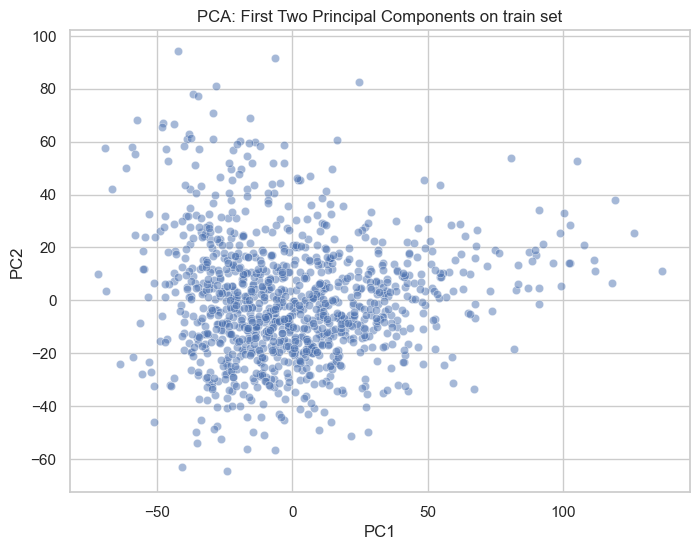

Top 5 explained variance ratio: [0.04930531 0.02659798 0.02036706 0.0173991  0.01579633]


In [21]:
scaler = StandardScaler()
train_feature_only = train_combined.drop(columns=['participant_id', "age"])
train_scaled = scaler.fit_transform(train_feature_only)  # Exclude non-feature columns

# Apply PCA
pca = PCA(n_components=1000)  # Start with 2 components for visualization
train_pca = pca.fit_transform(train_scaled)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=train_pca[:,:2], columns=['PC1', 'PC2'])

# Plot the PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, alpha=0.5)
plt.title('PCA: First Two Principal Components on train set')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Explained variance ratio
print(f"Top 5 explained variance ratio: {pca.explained_variance_ratio_[:5]}")

We see that in order to get how many number of PCs needed we plot the variance by number of PCs. We see with 400 PCs, we retain 80% of the data variance; and 800 PCs to retain 95% data variance. Thus, depending on the models later on, it's better to use between 400-800 PCs.

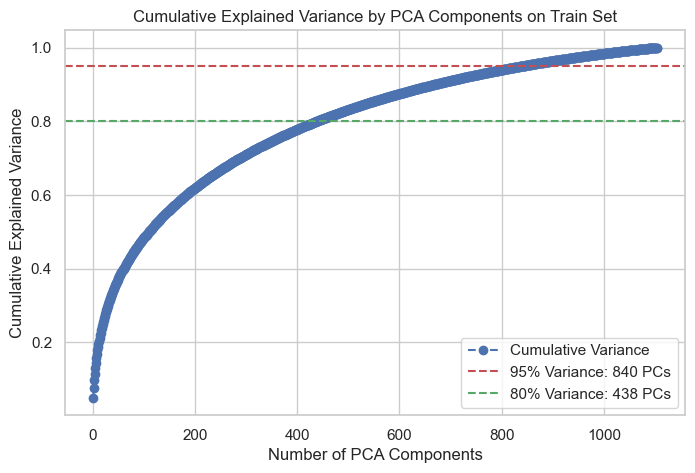

Number of PCA components needed for 80% variance: 438
Number of PCA components needed for 95% variance: 840


In [22]:
# Fit PCA on scaled training data
pca = PCA()
pca.fit(train_scaled)

# Compute cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Determine the number of components to reach 80% and 95% variance
num_components_80 = np.argmax(explained_variance >= 0.80) + 1  # First index where variance >= 80%
num_components_95 = np.argmax(explained_variance >= 0.95) + 1  # First index where variance >= 95%

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--', label="Cumulative Variance")

# Add reference lines for 80% and 95% variance
plt.axhline(y=0.95, color='r', linestyle='--', label=f'95% Variance: {num_components_95} PCs')
plt.axhline(y=0.80, color='g', linestyle='--', label=f'80% Variance: {num_components_80} PCs')

# Formatting the plot
plt.xlabel("Number of PCA Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance by PCA Components on Train Set")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Print the optimal number of components for 80% and 95% variance
print(f"Number of PCA components needed for 80% variance: {num_components_80}")
print(f"Number of PCA components needed for 95% variance: {num_components_95}")

In [23]:
test_scaled = scaler.transform(test_combined[train_feature_only.columns])
test_pca = pca.transform(test_scaled)[:, :1000] # Ensure same number of PCs as train


In [24]:
np.save(r'./widsdatathon2025-university/processed_data/train_pca.npy', train_pca)
np.save(r'./widsdatathon2025-university/processed_data/test_pca.npy', test_pca)

In [25]:
train_pca.shape

(1104, 1000)

In [26]:
test_pca.shape

(474, 1000)

# Developmental Trends in Brain Activity (Line Plot of Age vs. Connectivity Strength)

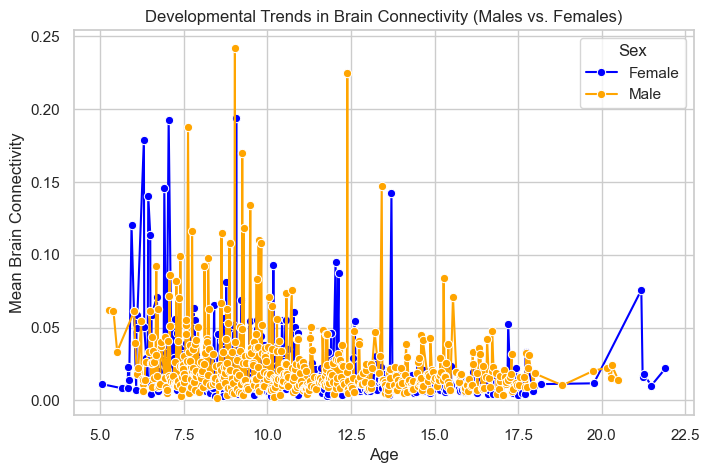

In [27]:
# Ensure mean connectivity is computed using the helper function
train_combined = compute_mean_connectivity(train_combined)

# Group by age and sex
grouped_data = train_combined.groupby(["age", "sex_Male"])["mean_connectivity"].mean().reset_index()

# Plot
plt.figure(figsize=(8, 5))

# Define a color palette for male (orange) and female (blue)
palette = {False: "blue", True: "orange"}

# Create the lineplot with specified colors
sns.lineplot(x="age", y="mean_connectivity", hue="sex_Male", data=grouped_data, marker="o", palette=palette)

# Set axis labels and title
plt.xlabel("Age")
plt.ylabel("Mean Brain Connectivity")
plt.title("Developmental Trends in Brain Connectivity (Males vs. Females)")

# Customize the legend to ensure both Male and Female appear with colors
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=["Female", "Male"], title="Sex", loc="upper right")

# Add grid
plt.grid(True)

# Show the plot
plt.show()

This graph illustrates how mean brain connectivity evolves across different ages for males and females. In early childhood (5-12 years), brain connectivity fluctuates significantly, with both sexes showing pronounced peaks. As children transition into adolescence (10-20 years), variability decreases, suggesting increasing neural efficiency and stabilization of brain networks.

Sex-based differences reveal that males tend to exhibit higher peaks in connectivity, especially during early adolescence, while females display a more stable pattern. These differences may be influenced by hormonal, cognitive, or structural factors in brain maturation. Understanding these patterns provides insights into neurodevelopment, mental health, and cognitive function during adolescence.

# Brain Connectivity vs. Psychological Traits

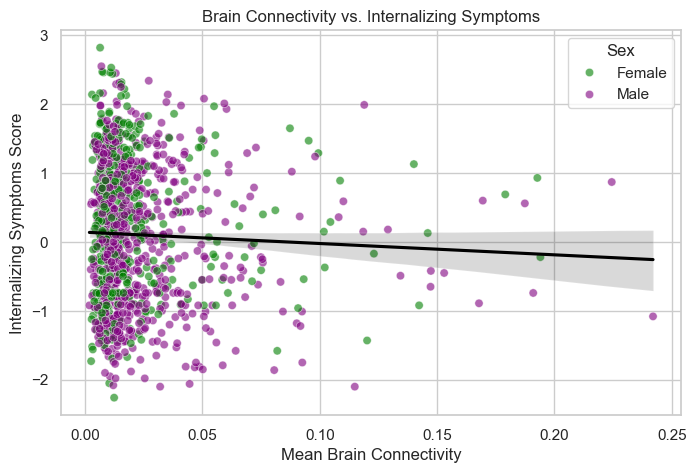

In [28]:
# Define a distinct color palette for this visualization
palette = {False: "green", True: "purple"}  # Female = Green, Male = Purple

# Create the scatter plot with regression line
plt.figure(figsize=(8, 5))

sns.scatterplot(
    x=train_combined["mean_connectivity"], 
    y=train_combined["internalizing_fs"], 
    hue=train_combined["sex_Male"], 
    palette=palette, 
    alpha=0.6
)

# Add regression line
sns.regplot(
    x=train_combined["mean_connectivity"], 
    y=train_combined["internalizing_fs"], 
    scatter=False, 
    color="black"
)

# Set axis labels and title
plt.xlabel("Mean Brain Connectivity")
plt.ylabel("Internalizing Symptoms Score")
plt.title("Brain Connectivity vs. Internalizing Symptoms")

# Fix legend to display correct labels with distinct colors
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=["Female", "Male"], title="Sex", loc="upper right")

# Show plot
plt.show()

Higher brain connectivity appears to be weakly associated with fewer internalizing symptoms, suggesting a possible relationship between neural network efficiency and mental health in adolescents. However, the trend indicates that connectivity alone is not a strong predictor of these symptoms. Females, represented in green, exhibit greater variability in both brain connectivity and internalizing symptoms, whereas males, shown in purple, display a more clustered distribution, indicating more consistent connectivity patterns across individuals. These findings highlight potential sex-based differences in brain development and suggest that connectivity may play a role in mental health outcomes.

# Top 10 Brain Region Differences by Sex

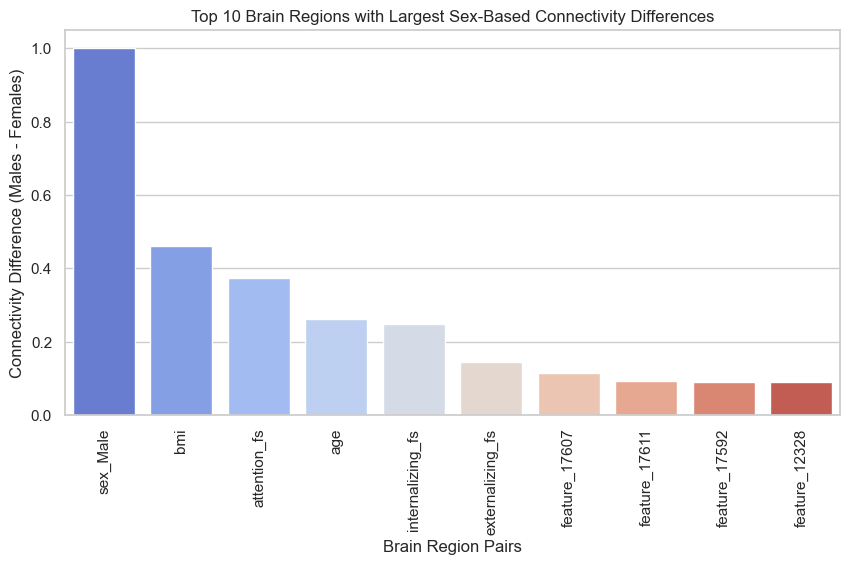

In [29]:
# Ensure mean connectivity is computed using the helper function
train_combined = compute_mean_connectivity(train_combined)

# Compute mean connectivity per gender
male_connectivity = train_combined[train_combined["sex_Male"] == True].mean(numeric_only=True)
female_connectivity = train_combined[train_combined["sex_Male"] == False].mean(numeric_only=True)

# Compute connectivity difference
connectivity_diff = male_connectivity - female_connectivity

# Get top 10 most different features
top_10_features = connectivity_diff.abs().nlargest(10)

# Plot bar chart
plt.figure(figsize=(10, 5))
sns.barplot(x=top_10_features.index, y=top_10_features.values, palette="coolwarm")
plt.xticks(rotation=90)
plt.ylabel("Connectivity Difference (Males - Females)")
plt.xlabel("Brain Region Pairs")
plt.title("Top 10 Brain Regions with Largest Sex-Based Connectivity Differences")
plt.show()

The visualization highlights the top 10 brain regions with the largest sex-based differences in connectivity. The most significant factor differentiating male and female connectivity is the variable sex_Male, shows the greatest difference, indicating a clear distinction in brain connectivity patterns between sexes. Other key contributors include BMI, attention scores, age, and internalizing/externalizing symptoms, indicating that physical and cognitive factors play a role in connectivity differences. Additionally, several specific brain region pairs (features) exhibit notable disparities, suggesting localized neural network variations between males and females. These findings emphasize the importance of considering both biological and psychological factors when analyzing sex-based differences in brain connectivity.

# **Summary of Exploratory Data Analysis (EDA) Insights**

---

### **Developmental Trends in Brain Connectivity**  
The analysis of functional brain connectivity across adolescence reveals **distinct age-related patterns**. Mean brain connectivity fluctuates significantly in early adolescence, showing **high variability between ages 7-14**, followed by a **gradual decline in variance with age**. These patterns suggest **dynamic changes in neural networks during childhood and adolescence**, likely driven by **cognitive and behavioral maturation**.

---

### **Sex-Based Differences in Brain Connectivity**  
Males and females exhibit **notable differences in brain connectivity and behavioral traits**.  
- **Females** tend to have **higher internalizing symptoms** (e.g., anxiety, depression), indicating **greater susceptibility to mood-related disorders**.  
- **Males** show **stronger externalizing behaviors** (e.g., impulsivity, aggression) and **greater attention-related difficulties**, aligning with **higher rates of ADHD and behavioral issues in boys**.  
- These differences suggest **sex-specific neural development pathways**, which could have implications for **mental health and cognitive function**.

---

### **Key Brain Regions Driving Sex-Based Differences**  
The **top 10 brain region pairs** with the largest sex-based differences highlight **significant associations** with **BMI, attention scores, internalizing/externalizing symptoms, and age**.  
- **These findings indicate that sex-based neural divergence is not uniform but rather concentrated in specific brain regions**.  
- The strong association between **mental health factors and brain connectivity** suggests that **neurobiological differences may contribute to cognitive and behavioral disparities across sexes**.

---

### **Principal Component Analysis (PCA) Insights**  
A **PCA analysis** of brain connectivity patterns identifies **key components that explain the most variance** in the data.  
- The cumulative variance plot reveals that **a relatively small subset of features captures most of the brain’s functional connectivity patterns**, enabling **dimensionality reduction for predictive modeling**.  
- These components may be useful for **developing predictive models of brain development, age, and mental health outcomes**.

---

### **T-Test and Statistical Validation**  
Statistical tests confirm that **sex differences in brain connectivity are highly significant**.  
- **Internalizing Symptoms:** **Females show significantly higher scores**, reinforcing their **greater vulnerability to emotional distress**.  
- **Externalizing Symptoms & Attention:** **Males exhibit significantly higher scores**, suggesting **greater challenges in impulse control and focus**.  
- These findings validate **neurodevelopmental distinctions between males and females**, supporting **theory-driven hypotheses in cognitive neuroscience**.

---

### **Conclusion & Implications**  
This analysis highlights **clear sex-based differences in brain connectivity, behavior, and mental health indicators**, suggesting that **neural development follows distinct pathways for males and females**. These findings have **critical implications for neuroscience, psychology, and clinical interventions**, emphasizing the need for **sex-specific approaches in mental health research and treatment during adolescence**.
